In [33]:
import numpy
from heapq import *
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Each node is in the format (x, y, r), where x and y are coordinates on the grid, and r is the rotation
# r = [0, 90, 180, 270]

def distance(a, b):
    """
    Returns the distance between node A and B
    """
    return (b[0] - a[0]) ** 2 + (b[1] - a[1]) ** 2

def rotation_heuristic(current, neighbor):
    """
    Rotation heuristic to punish turning
    Returns cost = 1 if robot has turned
    current: Initial node
    neighbor: Next node the robot is heading to
    """
    if current[2] != neighbor[2]:
        return 1
    
    return 0

def wall_heuristic(current, array):
    """
    Wall heuristic to punish staying close to the wall
    Returns the number of walls around the current node
    current: current node
    array: Grid world the robot is in
    """
    neighbors = [(1, 0), (-1, 0), (0, 1), (0, -1)]
    score = 0
    
    for i, j in neighbors:
        neighbor = current[0] + i, current[1] + j
        if 0 <= neighbor[0] < array.shape[0]:
            if 0 <= neighbor[1] < array.shape[1]:
                if array[neighbor[0]][neighbor[1]] == 1:
                    score += 1
                    continue
            else:
                # array bound y walls
                continue
        else:
            # array bound x walls
            continue
            
    return score

def get_neighbors(current, array):
    """
    Get all valid neighbors robot can travel to from current
    current: Current node
    array: Grid world the robot is in
    """
    neighbors = [] # Final list of neighbors
    orientation = current[2] # Current orientation on node
    
    # Get all possible neighbors relative to the current location
    # We want a 3x3 turn (spans 3 grid cells length and widthwise), hence turns are ( +-2, +-2, +-90 )
    if orientation == 0 or orientation == 180:
        relative_neighbors = [(1, 0, 0), (-1, 0, 0), (-2, 2, 90), (-2, -2, -90), (2, -2, 90), (2, 2, -90)]
    elif orientation == 90 or orientation == 270:
        relative_neighbors = [(0, 1, 0), (0, -1, 0), (-2, 2, -90), (2, 2, 90), (-2, -2, 90), (2, -2, -90)]
    
    for i, j, rotation in relative_neighbors:
        neighbor = current[0] + i, current[1] + j, (current[2] + rotation) % 360
        
        # Skip squares outside of the grid
        if (neighbor[0] < 0 or neighbor[0] >= array.shape[0]): # out of range
            continue
        if (neighbor[1] < 0 or neighbor[1] >= array.shape[1]): # out of range
            continue
        if array[neighbor[0]][neighbor[1]] == 1: # is a wall
            continue

        # If i am not turning, I do not need to check if the turn was legal
        if current[2] == neighbor[2]:
            neighbors.append(neighbor)
            continue
            
        # Check squares on the turn path are not walls, to ensure robot does not pass through walls
        if current[2] == 90 or current[2] == 270: # If I was facing left/right
            if neighbor[1] > current[1]: # and I am moving rightwards
                if neighbor[0] > current[0]: # and I am moving down
                    nodes_to_check = [
                        (current[0], current[1] + 1), 
                        (current[0], current[1] + 2), 
                        (current[0] + 1, current[1] + 1), 
                        (current[0] + 1, current[1] + 2)]
                else: # and I am moving up
                    nodes_to_check = [
                        (current[0], current[1] + 1), 
                        (current[0], current[1] + 2), 
                        (current[0] - 1, current[1] + 1), 
                        (current[0] - 1, current[1] + 2)]
            else: # and I am moving leftwards
                if neighbor[0] > current[0]: # and I am moving down
                    nodes_to_check = [
                        (current[0], current[1] - 2), 
                        (current[0], current[1] - 1), 
                        (current[0] + 1, current[1] - 2), 
                        (current[0] + 1, current[1] - 1)]
                else: # and I am moving up
                    nodes_to_check = [
                        (current[0], current[1] - 2), 
                        (current[0], current[1] - 1), 
                        (current[0] - 1, current[1] - 2), 
                        (current[0] - 1, current[1] - 1)]
        else: # If i was facing up/down
            if neighbor[0] > current[0]: # and I am moving downwards
                if neighbor[1] > current[1]: # and I am moving rightwards
                    nodes_to_check = [
                        (current[0] + 1, current[1]), 
                        (current[0] + 1, current[1] + 1), 
                        (current[0] + 2, current[1]), 
                        (current[0] + 2, current[1] + 1)
                    ]
                else: # and I am moving left
                    nodes_to_check = [
                        (current[0] + 1, current[1] - 1), 
                        (current[0] + 1, current[1]), 
                        (current[0] + 2, current[1] - 1), 
                        (current[0] + 2, current[1])
                    ]
            else: # and I am moving upwards
                if neighbor[1] > current[1]: # and I am moving rightwards
                    nodes_to_check = [
                        (current[0] - 2, current[1]), 
                        (current[0] - 2, current[1] + 1), 
                        (current[0] - 1, current[1]), 
                        (current[0] - 1, current[1] + 1)]
                else: # and I am moving leftwards
                    nodes_to_check = [
                        (current[0] - 2, current[1] - 1), 
                        (current[0] - 2, current[1]), 
                        (current[0] - 1, current[1] - 1), 
                        (current[0] - 1, current[1])]
        
        # If any node we are supposed to pass through is a wall, we skip this neighbor
        if any([array[node[0]][node[1]] == 1 for node in nodes_to_check]):
            continue
                        
        # If all checks pass, neighbor is valid and reachable from current node
        neighbors.append(neighbor)
    return neighbors

def a_star(array, start, goal):
    """
    Performs a* search from start to goal, through the array world
    Returns an array of nodes which represents the path 
    Returns False if path not found
    """
    # 0 is up, 90 is right, 180 is down, 270 is left
    close_set = set()
    came_from = {}
    gscore = {start: 0}
    fscore = {start: distance(start, goal)}
    oheap = []
    multiplier = array.shape[0] * array.shape[1]

    heappush(oheap, (fscore[start], start))

    while oheap:
        current = heappop(oheap)[1]
        neighbors = get_neighbors(current, array)
        
        if current == goal:
            data = []
            while current in came_from:
                data.append(current)
                current = came_from[current]
            data.append(start)
            return data

        close_set.add(current)
        
        
        for neighbor in neighbors:
            tentative_g_score = gscore[current] + distance(current, neighbor) + multiplier * wall_heuristic(neighbor, array) + multiplier * rotation_heuristic(current, neighbor)
        
            if neighbor in close_set and tentative_g_score >= gscore.get(neighbor, 0):
                continue

            if tentative_g_score < gscore.get(neighbor, 0) or neighbor not in [i[1] for i in oheap]:
                came_from[neighbor] = current
                gscore[neighbor] = tentative_g_score
                fscore[neighbor] = tentative_g_score + distance(neighbor, goal)
                heappush(oheap, (fscore[neighbor], neighbor))

    return False

def a_star_multiple_goals(grid, start, *goals):
    """
    Travels from start, to goal[0], goal[1], ..., goal[n] in order
    grid: Grid world
    start: Starting location
    goals: 1 or more goals
    E.g. a_star_multiple_goals(array, (0, 0, 0), (1, 2, 90), (5, 5, 90))
    """
    overall_path = []
    nodes_to_travel_to = [start] + [k for k in goals]
    
    for i in range(len(nodes_to_travel_to) - 1):
        path = a_star(grid, nodes_to_travel_to[i], nodes_to_travel_to[i + 1])
        if not path:
            return False
        
        overall_path = overall_path + path[::-1]
        
    return overall_path

In [40]:
def display(grid, path, waypoints):
    """
    Given a path, grid, and waypoints, show the path to the user
    """
    WIDTH = 10
    HEIGHT = 10
    fig, ax = plt.subplots(figsize=(20, 20))
    
    for waypoint in waypoints:
        rectangle = patches.Rectangle((10 * waypoint[1], 10 * waypoint[0]), 10, 10, linewidth=5, edgecolor='r', facecolor='g')
        ax.add_patch(rectangle)  
    
    # Fill in grid and walls
    for i in range(len(grid)):
        for j in range(len(grid[i])):
            if grid[i][j] == 0:
                rectangle = patches.Rectangle((WIDTH * j, HEIGHT * i), WIDTH, HEIGHT, linewidth=1, edgecolor='r', facecolor='none')
            else:
                rectangle = patches.Rectangle((WIDTH * j, HEIGHT * i), WIDTH, HEIGHT, linewidth=1, edgecolor='r', facecolor='gray')
            ax.add_patch(rectangle)
    
    if not path: # Path not found
        print("No path")
        ax.margins(0)
        plt.show()
        return
    
    print("Path", path)
    
    # Draw path
    prev = None
    for i, j, rotation in path:
        # Draw the turns
        if prev is not None:
#             if prev[2] == 90 or prev[2] == 270:
#                 rectangle = patches.Rectangle((WIDTH * j, HEIGHT * prev[0]), WIDTH, HEIGHT, linewidth=1, edgecolor='r', facecolor=(0, 0, 1, 0.2))
#                 ax.add_patch(rectangle)
#             else:
#                 rectangle = patches.Rectangle((WIDTH * prev[1], HEIGHT * i), WIDTH, HEIGHT, linewidth=1, edgecolor='r', facecolor=(0, 0, 1, 0.2))
#                 ax.add_patch(rectangle)
            
            change_in_angle = (rotation - prev[2]) % 360
            change_in_x = i - prev[0]
            change_in_y = j - prev[1]
            
            if change_in_angle == 90:
                turn_direction = "left"
            elif change_in_angle == 270:
                turn_direction = "right"
            else:
                turn_direction = "straight"
                
            if (prev[2] == 0 and change_in_x < 0) or (prev[2] == 90 and change_in_y > 0) or (prev[2] == 180 and change_in_x > 0) or (prev[2] == 270 and change_in_y < 0):
                move_direction = "forward"
            else:
                move_direction = "backward"
                
            print("Go", turn_direction, move_direction, "from", prev, "to", (i, j, rotation))
            
            # plot line of travel
            ax.plot([prev[1] * WIDTH + WIDTH / 2, j * WIDTH + WIDTH / 2], [prev[0] * HEIGHT + HEIGHT / 2, i * HEIGHT + HEIGHT / 2], 'ro-')
        
        # Highlight path node if node is not a waypoint
        if (i, j) not in [(a, b) for a, b, c in waypoints]:
            rectangle = patches.Rectangle((WIDTH * j, HEIGHT * i), WIDTH, HEIGHT, linewidth=1, edgecolor='r', facecolor=(0, 0, 1, 0.2))
            ax.add_patch(rectangle)
        
        # Draw directional arrow
        if rotation == 0:
            plt.arrow(WIDTH * j + WIDTH / 2, HEIGHT * i + HEIGHT, 0, -HEIGHT, head_width=2, width=1, length_includes_head=True)
        elif rotation == 90:
            plt.arrow(WIDTH * j, HEIGHT * i + HEIGHT / 2, WIDTH, 0, head_width=2, width=1, length_includes_head=True)
        elif rotation == 180:
            plt.arrow(WIDTH * j + WIDTH / 2, HEIGHT * i, 0, HEIGHT, head_width=2, width=1, length_includes_head=True)
        else:
            plt.arrow(WIDTH * j + WIDTH, HEIGHT * i + HEIGHT / 2, -WIDTH, 0, head_width=2, width=1, length_includes_head=True)
        
        prev = (i, j, rotation) 
        
    ax.margins(0)
    plt.show()

Path [(0, 0, 90), (0, 1, 90), (0, 2, 90), (0, 3, 90), (2, 5, 180), (3, 5, 180), (4, 5, 180), (6, 3, 270), (6, 4, 270), (4, 2, 0), (4, 2, 0), (6, 0, 90), (6, 1, 90), (4, 3, 0), (4, 3, 0), (5, 3, 0), (6, 3, 0), (7, 3, 0), (8, 3, 0), (10, 5, 270), (10, 6, 270), (10, 7, 270), (10, 8, 270), (10, 9, 270), (10, 10, 270), (10, 10, 270), (10, 9, 270), (10, 8, 270), (10, 7, 270), (8, 9, 180), (9, 9, 180), (11, 11, 90), (11, 12, 90), (11, 13, 90)]
Go straight forward from (0, 0, 90) to (0, 1, 90)
Go straight forward from (0, 1, 90) to (0, 2, 90)
Go straight forward from (0, 2, 90) to (0, 3, 90)
Go left forward from (0, 3, 90) to (2, 5, 180)
Go straight forward from (2, 5, 180) to (3, 5, 180)
Go straight forward from (3, 5, 180) to (4, 5, 180)
Go left forward from (4, 5, 180) to (6, 3, 270)
Go straight backward from (6, 3, 270) to (6, 4, 270)
Go left forward from (6, 4, 270) to (4, 2, 0)
Go straight backward from (4, 2, 0) to (4, 2, 0)
Go left backward from (4, 2, 0) to (6, 0, 90)
Go straight forw

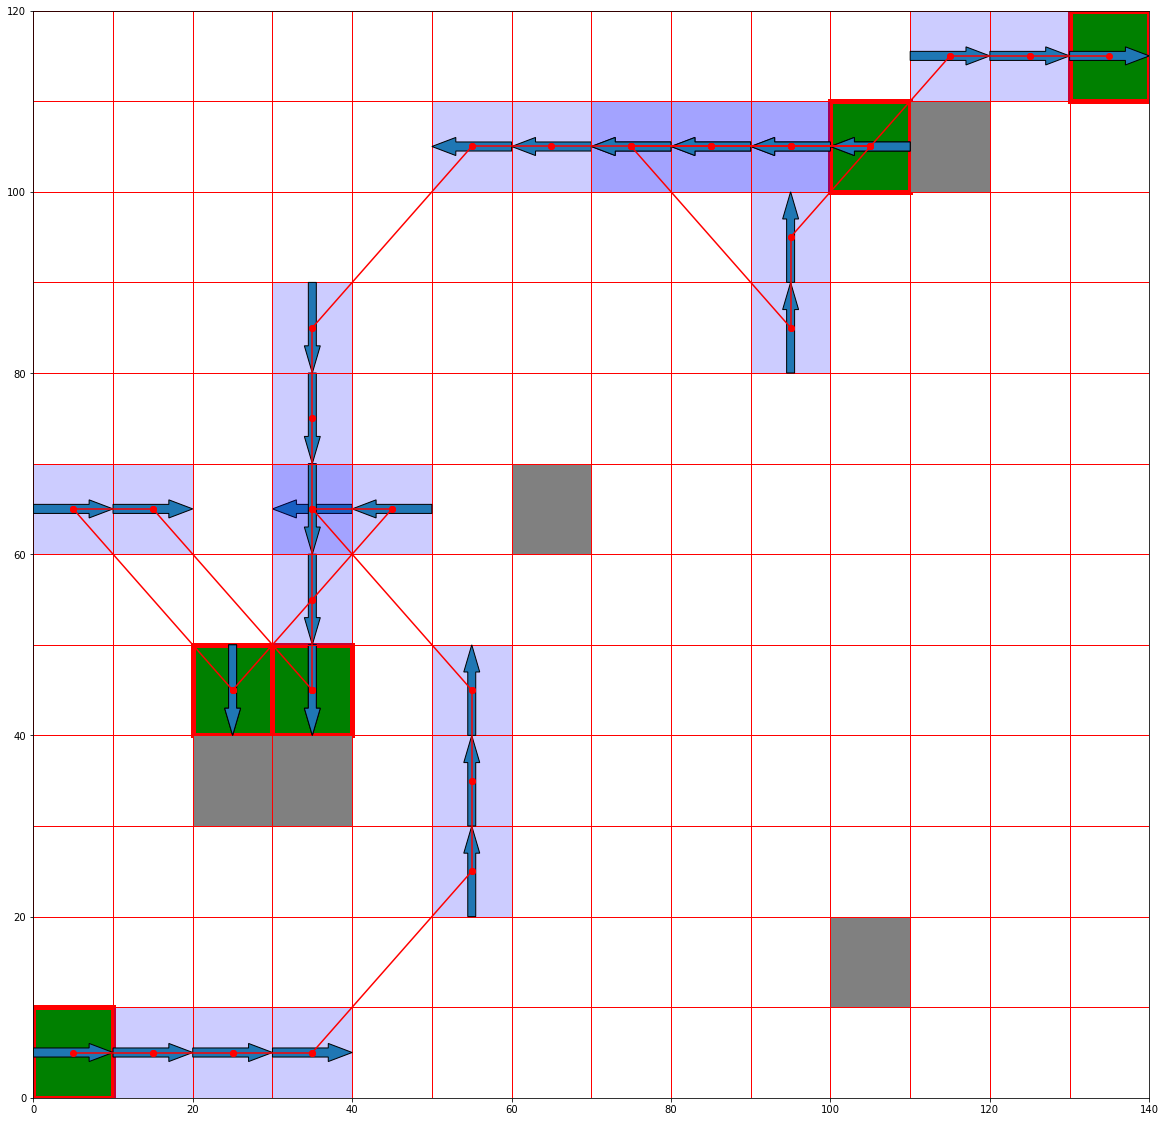

In [41]:
nmap = numpy.array([
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
waypoints = [(0, 0, 90), (4, 2, 0), (4, 3, 0), (10, 10, 270), (nmap.shape[0] - 1, nmap.shape[1] - 1, 90)]

# nmap = numpy.array([
#     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
#     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
#     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
#     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
#     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
#     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
#     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
#     [1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
#     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
#     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
#     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
#     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
#     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
#     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
#     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
#     [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
#     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
#     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
# waypoints = [(0, 0, 90), (nmap.shape[0] - 1, nmap.shape[1] - 1, 90)]

path = a_star_multiple_goals(nmap, waypoints[0], *waypoints[1:])

if path:
    display(nmap, path, waypoints)
else:
    print("No path")
    